In [14]:
def is_corner(G,v):
    V = G.vertices();
    N = set(G.neighbors(v,closed=True));
    for u in V:
        if u != v:
            M = set(G.neighbors(u,closed=True));
            if N.issubset(M):
                return True
    return False

In [15]:
def is_copwin(G):
    H = Graph(G);
    V = H.vertices();
    n = len(V);
    if n == 1:
        return True
    for u in V:
        if is_corner(H,u):
            H.delete_vertex(u);
            return is_copwin(H)
    return False

In [16]:
def CRel(G,p):
    P = 0
    E = G.edges()
    m = len(E)
    C = Combinations(E).list()
    for U in C:
        H = G.subgraph(edges=U)
        if is_copwin(H):
            k = len(H.edges())
            P += p^k*(1-p)^(m-k)
    return P

def multiCRel(thread, outputQueue):
    for arr in thread:
        G = arr[0]
        p = arr[1]
        P = CRel(G, p)
        outputQueue.put([G,P])


In [17]:
import os
import multiprocessing as mp

#update nautyloc to fit your system?
#here we run nauty to get the graphs I want

f = open("./unicyclic6.g6","r");
g = open("./CRelUnicyclic6.txt","w");

In [18]:
# cyclic is a boolean: false means it's unicyclic, true means its bicyclic
def generate_graphs(order, unicyclic):
    name = ""
    if unicyclic:
        name = "./unicyclic" + str(order) + ".g6"
    else:
        name = "./bicyclic" + str(order) + ".g6"
    os.system('geng -c ' + str(order) + ' ' + str(order) + ':' + str(order) + ' > ' + name)
generate_graphs(10, False)

>A geng -cd1D9 n=10 e=10
>Z 657 graphs generated in 0.00 sec


In [19]:
def graphanalysis(infileName, outfileName, num_threads):
    f = open(infileName, "r")
    g = open(outfileName, "w")
    x = SR.var('x'); #needed for converting string back to polynomial in second loop
    m = -1; #initialize the max value at 1/2
    noOptimal = False;
    index = 0; #keeps track of where in the file we are
    
    threadTasks = []
    for i in range(num_threads):
        threadTasks.append([])
        
    taskAssign = 0

    processArray = []
    
    outputLineQueue = mp.Queue()
    
    for line in f.readlines():
        index += 1;
        G = Graph(line);
        
        threadTasks[taskAssign].append([G,x])

        taskAssign = taskAssign + 1
        allGraphs = allGraphs + 1

        if (taskAssign == num_threads):
            taskAssign = 0
        
        
    for thread in threadTasks:
        process = mp.Process(target = multiCRel, args = (thread, outputLineQueue))
        process.start()
        processArray.append(process)


    for process in processArray:
        process.join()
        process.close()
        
    outputLength = 0
    outputTarget = outputLineQueue.qsize()
    
    while outputLength != outputTarget:
        outputArr = outputLineQueue.get()
        G = outputArr[0]
        N = outputArr[1]
        val = N(x = 1/2);
        if val > m: # if we find a larger rel at 1/2 update the variables accordingly
            m = val;
            maxGraph = G;
            maxRel = N;
            maxIndex = index;
        outputLength += 1
        g.write(str(N)+'\r\n'); #write the polynomial to a file so we don't have to compute them again when checking if the max at 1/2 is a the max

    
    g = open(outfileName,"r");
    index = 0; #reset index counter
    for line in g.readlines():  #loop covers all other NCRels to see if there are any crossings in the interval (0,1)
        index+=1;
        if index != maxIndex:
            N = SR(line); #converts string back to a polynomial in the symbolic ring
            diff = N - maxRel;
            rts = diff.roots(multiplicities=False,ring=RDF); #solves for real roots of the difference polynomial
            for r in rts:
                if 0<r<0.9999999999: #error occurs so can't use 1, hoping this is enough of a buffer
                    noOptimal = True;
                    break;
            if noOptimal:
                 break;
    if noOptimal == False:
        maxGraph.show()
        print(maxRel)
    else:
        print('More investigation required:')
        print(N)
        print('Root index',index)
        print(maxRel)
        print('Max Index',maxIndex)
        
minnodes = 5
maxnodes = 6
unicyclic = true

graphType = "unicyclic" if unicyclic else "bicyclic"


for i in range(minnodes, maxnodes):
    print("analysing graphs of order " + str(i))
    generate_graphs(i, unicyclic)
    graphanalysis("./" + graphType + str(i) + ".g6", "./CRel" + graphType + str(i) + ".txt")


analysing graphs of order 5
More investigation required:
-3*(x - 1)*x^4 + x^5
Root index 1
-5*(x - 1)*x^4
Max Index 5


>A geng -cd1D4 n=5 e=5
>Z 5 graphs generated in 0.00 sec


In [20]:
diff = N - maxRel;
rts = diff.roots(multiplicities=False,ring=RDF);
rts

NameError: name 'maxRel' is not defined

In [ ]:
f = open("graph_data/unicyclic4.g6","r");
g = open("graph_data/CRelUnicyclic4.txt","w");

In [ ]:
x = SR.var('x'); #needed for converting string back to polynomial in second loop
m = -1; #initialize the max value at 1/2
noOptimal = False;
index = 0; #keeps track of where in the file we are
for line in f.readlines():
    index += 1;
    G = Graph(line);
    N = CRel(G,x);
    val = N(1/2);
    if val > m: # if we find a larger rel at 1/2 update the variables accordingly
        m = val;
        maxGraph = G;
        maxRel = N;
        maxIndex = index;
    g.write(str(N)+'\r\n'); #write the polynomial to a file so we don't have to compute them again when checking if the max at 1/2 is a the max
    
g = open("graph_data/CRelUnicyclic5.txt","r");
index = 0; #reset index counter
for line in g.readlines():  #loop covers all other NCRels to see if there are any crossings in the interval (0,1)
    index+=1;
    if index != maxIndex:
        N = SR(line); #converts string back to a polynomial in the symbolic ring
        diff = N - maxRel;
        rts = diff.roots(multiplicities=False,ring=RDF); #solves for real roots of the difference polynomial
        for r in rts:
            if 0<r<0.9999999999: #error occurs so can't use 1, hoping this is enough of a buffer
                noOptimal = True;
                break;
        if noOptimal:
             break;
if noOptimal == False:
    maxGraph.show()
    print(maxRel)
else:
    print('More investigation required:')
    print(N)
    print('Root index',index)
    print(maxRel)
    print('Max Index',maxIndex)

In [ ]:
f = open("graph_data/unicyclic6.g6","r");
g = open("graph_data/CRelUnicyclic6.txt","w");

x = SR.var('x'); #needed for converting string back to polynomial in second loop
m = -1; #initialize the max value at 1/2
noOptimal = False;
index = 0; #keeps track of where in the file we are
for line in f.readlines():
    index += 1;
    G = Graph(line);
    N = CRel(G,x);
    val = N(1/2);
    if val > m: # if we find a larger rel at 1/2 update the variables accordingly
        m = val;
        maxGraph = G;
        maxRel = N;
        maxIndex = index;
    g.write(str(N)+'\r\n'); #write the polynomial to a file so we don't have to compute them again when checking if the max at 1/2 is a the max
    
g = open("graph_data/CRelUnicyclic6.txt","r");
index = 0; #reset index counter
for line in g.readlines():  #loop covers all other NCRels to see if there are any crossings in the interval (0,1)
    index+=1;
    if index != maxIndex:
        N = SR(line); #converts string back to a polynomial in the symbolic ring
        diff = N - maxRel;
        rts = diff.roots(multiplicities=False,ring=RDF); #solves for real roots of the difference polynomial
        for r in rts:
            if 0<r<0.9999999999: #error occurs so can't use 1, hoping this is enough of a buffer
                noOptimal = True;
                break;
        if noOptimal:
             break;
if noOptimal == False:
    maxGraph.show()
    print(maxRel)
else:
    print('More investigation required:')
    print(N)
    print('Root index',index)
    print(maxRel)
    print('Max Index',maxIndex)

In [21]:
def CW(G,x):
    P = 0
    E = G.edges()
    n = len(E)
    C = Combinations(E).list()
    for U in C:
        H = G.subgraph(edges = U)
        if is_copwin(H):
            k = H.order()
            P += x^k
    return P

True


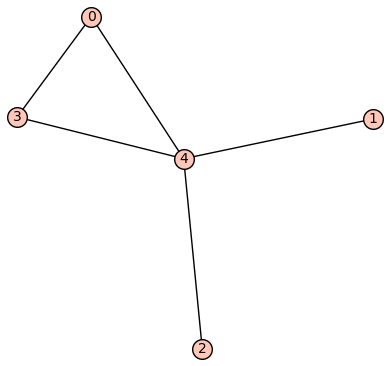

bigger at coeff 5
False


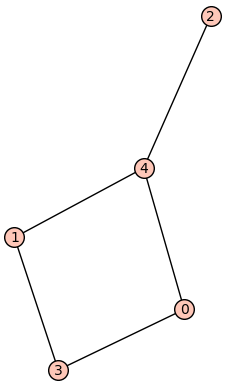

bigger at coeff 5
True


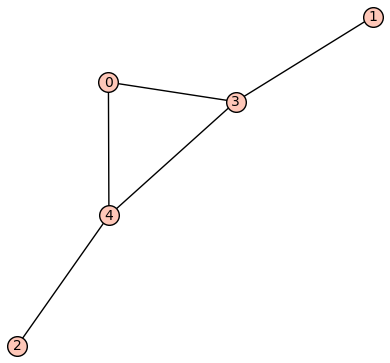

bigger at coeff 5
True


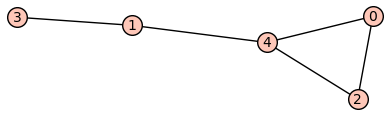

bigger at coeff 5
False


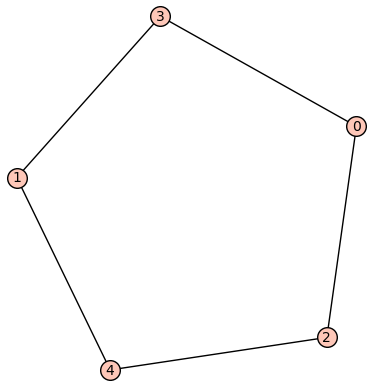

bigger at coeff 5
Total of 5 graphs


In [26]:
n = 5;
f = open("unicyclic" + str(n) + ".g6","r");
index = 0
for line in f:
    index += 1;
    G = Graph(line);
    print(is_copwin(G))
    N = CW(G,x);
    l = N.list();
    for k in range(3,len(l)):
        if l[k] > binomial(n-1,k-1):
            G.show()
            print('bigger at coeff',k)
print("Total of " + str(index) + " graphs")

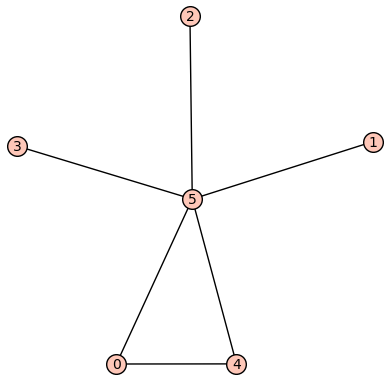

bigger at coeff 6


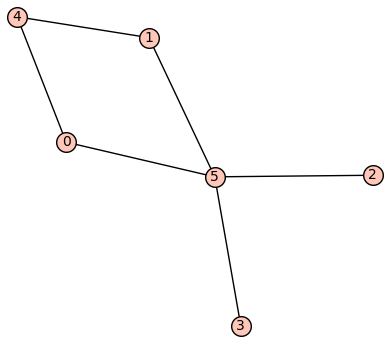

bigger at coeff 6


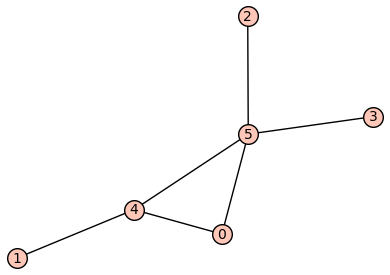

bigger at coeff 6


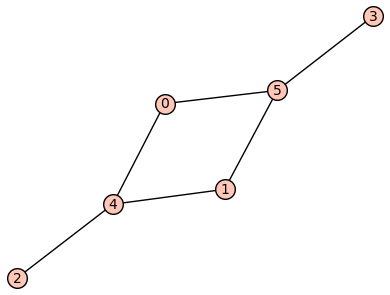

bigger at coeff 6


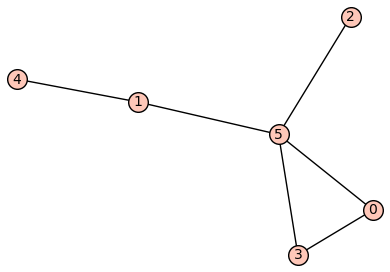

bigger at coeff 6


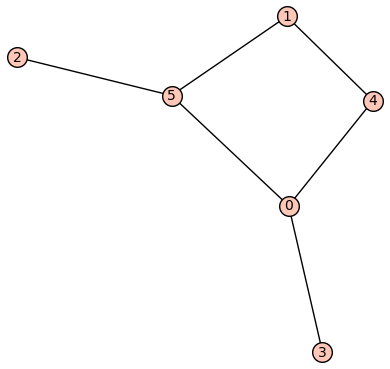

bigger at coeff 6


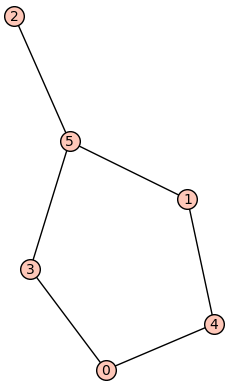

bigger at coeff 6


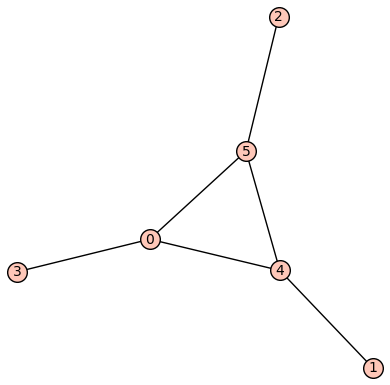

bigger at coeff 6


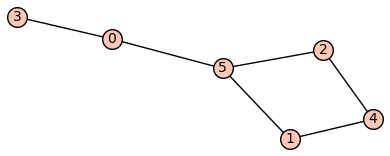

bigger at coeff 6


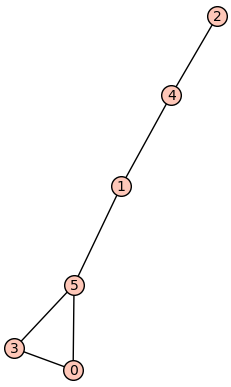

bigger at coeff 6


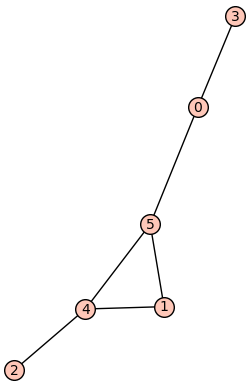

bigger at coeff 6


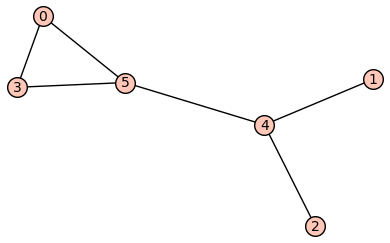

bigger at coeff 6


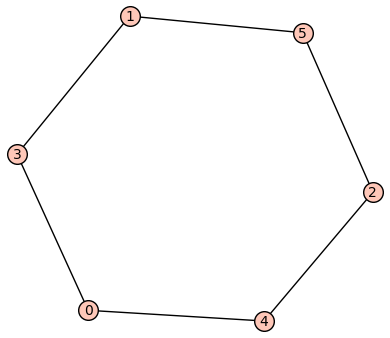

bigger at coeff 6
Total of 13 graphs


In [25]:
n = 6;
f = open("unicyclic" + str(n) + ".g6","r");
index = 0
for line in f:
    index += 1;
    G = Graph(line);
    N = CW(G,x);
    l = N.list();
    for k in range(3,len(l)):
        if l[k] > binomial(n-1,k-1):
            G.show()
            print('bigger at coeff',k)
print("Total of " + str(index) + " graphs")